Full Training Epoch 0, Loss: 1.770974
Full Training Epoch 500, Loss: 0.000004
Full Training Epoch 1000, Loss: 0.000001
Full Training Epoch 1500, Loss: 0.000000
Full Training Epoch 2000, Loss: 0.000000
Full Training Epoch 2500, Loss: 0.000000
Full Training Epoch 3000, Loss: 0.000000
Full Training Epoch 3500, Loss: 0.000002
Full Training Epoch 0, Loss: 2.033475
Full Training Epoch 500, Loss: 0.000010
Full Training Epoch 1000, Loss: 0.000001
Full Training Epoch 1500, Loss: 0.000000
Full Training Epoch 2000, Loss: 0.000000
Full Training Epoch 2500, Loss: 0.000000
Full Training Epoch 3000, Loss: 0.000000
Full Training Epoch 3500, Loss: 0.000000


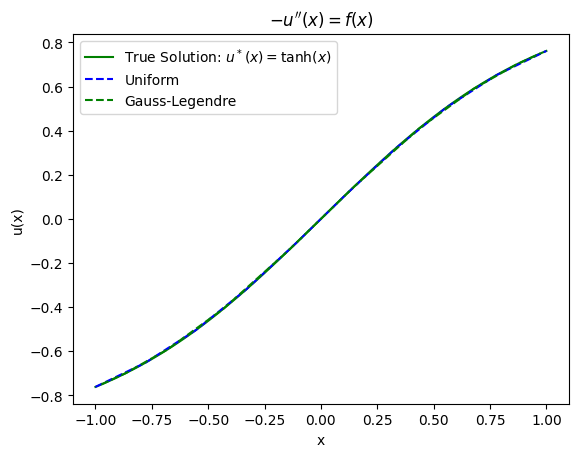

In [4]:
#imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import roots_legendre

#global constants
EPSILON = .01

#PROBLEM:
# -d^2u / dx^2 = f
# u(-1) = tanh(-1)
# u(1) = tanh(1)

#define PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

#neural network functions
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
create_graph=True)[0]

def forcing_function(x):
    return 2*torch.tanh(x)/(torch.cosh(x))**2


def compute_loss(model: nn.Module, x: torch.Tensor):
    #evaluating u(x), f(x), du/dx, d^2u/dx^2 at collocation points x
    x.requires_grad_(True)
    u = model(x)
    du = grad(u,x)
    d2u = grad(du,x)
    f = forcing_function(x)

    #ODE residual: -u"(x) - f(x)
    residual = -d2u - f
    interior_loss = torch.mean(residual ** 2)

    #calculating boundary loss for problem
    left_residual = model(torch.tensor([-1.0])) - torch.tanh(torch.tensor([-1.0]))
    right_residual = model(torch.tensor([1.0])) - torch.tanh(torch.tensor([1.0]))
    boundary_loss = torch.mean(left_residual ** 2 + right_residual ** 2)

    return interior_loss + boundary_loss


#Generating collocation points
def generate_collocation_points(method='uniform', num_points=10):
    if method == 'uniform':
        x_train = np.linspace(-1, 1, num_points)
    elif method == 'gauss_legendre':
        x_train = roots_legendre(num_points)[0]
    else:
        raise ValueError("Unsupported quadrature method")

    return torch.tensor(x_train.reshape(-1,1), dtype=torch.float32)

def train_PINN(x_train):
    # Training the PINN
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Iterate training over epochs
    for epoch in range(4000):
        loss = compute_loss(model, x_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Full Training Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

# Helper function to plot results
def create_results(x_train, color='red', label=''):
    model = train_PINN(x_train)
    y_pred = model(x_train).detach().numpy()
    plt.plot(x_train.detach().numpy(), y_pred, label=label, color=color, linestyle='--')

if __name__ == "__main__":
    # Plotting True Result
    x_test = torch.linspace(-1, 1, 100).reshape(-1, 1)
    y_true = torch.tanh(x_test).numpy()
    plt.plot(x_test.numpy(), y_true, label= r'True Solution: $u^*(x) = \tanh(x)$', color='green')

    # Getting Collocation Points and weights
    uniform = generate_collocation_points(method='uniform')
    gauss_legendre = generate_collocation_points(method='gauss_legendre')

    #Plotting results
    create_results(uniform, color='blue',label='Uniform')
    create_results(gauss_legendre, color='green',label='Gauss-Legendre')

    #Plotting Prettiness
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    title = r"$-u''(x) = f(x)$"
    plt.title(title)
    plt.show()

Full Training Epoch 0, Loss: 5.730142
Full Training Epoch 500, Loss: 0.000013
Full Training Epoch 1000, Loss: 0.000003
Full Training Epoch 1500, Loss: 0.000002
Full Training Epoch 2000, Loss: 0.000001
Full Training Epoch 2500, Loss: 0.000000
Full Training Epoch 3000, Loss: 0.000003
Full Training Epoch 3500, Loss: 0.000002
Full Training Epoch 0, Loss: 4.403804
Full Training Epoch 500, Loss: 0.000005
Full Training Epoch 1000, Loss: 0.000004
Full Training Epoch 1500, Loss: 0.000005
Full Training Epoch 2000, Loss: 0.000004
Full Training Epoch 2500, Loss: 0.000004
Full Training Epoch 3000, Loss: 0.000004
Full Training Epoch 3500, Loss: 0.000041


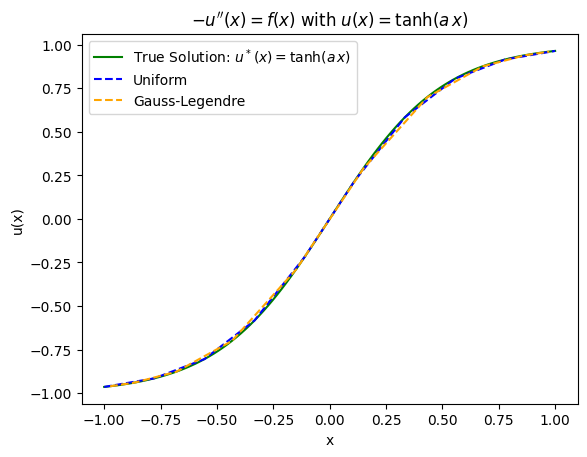

In [5]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import roots_legendre

# global constants
# scale parameter for the exact solution u(x) = tanh(a * x)
a = 2.0
EPSILON = .01

# PROBLEM:
#   -d^2u / dx^2 = f(x)
#   u(-1) = tanh(a * -1)
#   u(1)  = tanh(a *  1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20), # input layer mapping 1 → 20 neurons
            nn.Tanh(), # Hyperbolic-tangent activation
            nn.Linear(20, 20), # Hidden layer mapping 20 → 20
            nn.Tanh(), # Tanh activation
            nn.Linear(20, 1) # Output layer mapping 20 → 1
        )

    # Defines the forward pass: given a tensor x of shape (N,1), returns shape (N,1)
    def forward(self, x):
        return self.net(x)

# automatic gradient helper
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
        )[0]

# updated forcing to match u(x) = tanh(a*x)
def forcing_function(x):
    # -u'' = 2 * a^2 * tanh(a x) * sech^2(a x)
    return 2 * a**2 * torch.tanh(a * x) / (torch.cosh(a * x))**2

# compute combined interior + boundary loss
def compute_loss(model: nn.Module, x: torch.Tensor):
    x.requires_grad_(True)
    u    = model(x)
    du   = grad(u, x)
    d2u  = grad(du, x)
    f    = forcing_function(x)

    # ODE residual
    residual      = -d2u - f
    interior_loss = torch.mean(residual**2) # mean squared residual over all interior points.

    # boundary residuals at x = -1, +1
    left_res  = model(torch.tensor([[-1.0]], dtype=torch.float32)) - torch.tanh(a * torch.tensor([[-1.0]], dtype=torch.float32))
    right_res = model(torch.tensor([[ 1.0]], dtype=torch.float32)) - torch.tanh(a * torch.tensor([[ 1.0]], dtype=torch.float32))
    boundary_loss = torch.mean(left_res**2 + right_res**2)

    return interior_loss + boundary_loss

# collocation point generator (uniform or Gauss-Legendre)
def generate_collocation_points(method='uniform', num_points=10):
    if method == 'uniform':
        x_train = np.linspace(-1, 1, num_points)
    elif method == 'gauss_legendre':
        x_train = roots_legendre(num_points)[0]
    else:
        raise ValueError('Unsupported quadrature method')

    return torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)

# training routine
def train_PINN(x_train):
    model     = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(4000):
        loss = compute_loss(model, x_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f'Full Training Epoch {epoch}, Loss: {loss.item():.6f}')

    return model

# helper to train & plot a solution
def create_results(x_train, color='red', label=''):
    model  = train_PINN(x_train)
    y_pred = model(x_train).detach().numpy()
    plt.plot(x_train.detach().numpy(), y_pred, label=label, color=color, linestyle='--')

# Ensures that the following code only runs when the script is executed directly (not when imported as a module).
if __name__ == '__main__':
    # true solution with parameter a
    x_test = torch.linspace(-1, 1, 100).reshape(-1, 1)
    y_true = torch.tanh(a * x_test).numpy()
    plt.plot(x_test.numpy(), y_true, label=r'True Solution: $u^*(x)=\tanh(a\,x)$', color='green')

    # collocation sets. Prepares two distinct training sets: one uniform, one Gauss–Legendre.
    uniform       = generate_collocation_points(method='uniform')
    gauss_legendre = generate_collocation_points(method='gauss_legendre')

    # train & plot
    create_results(uniform,       color='blue',  label='Uniform')
    create_results(gauss_legendre, color='orange', label='Gauss-Legendre')

    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.title(r"$-u''(x)=f(x)$ with $u(x)=\tanh(a\,x)$")
    plt.show()


Full Training Epoch 0, Loss: 4.842540
Full Training Epoch 500, Loss: 0.101816
Full Training Epoch 1000, Loss: 0.002000
Full Training Epoch 1500, Loss: 0.001294
Full Training Epoch 2000, Loss: 0.011342
Full Training Epoch 2500, Loss: 0.001304
Full Training Epoch 3000, Loss: 0.001054
Full Training Epoch 3500, Loss: 0.000913
Full Training Epoch 0, Loss: 32.082531
Full Training Epoch 500, Loss: 0.563332
Full Training Epoch 1000, Loss: 0.130909
Full Training Epoch 1500, Loss: 0.002630
Full Training Epoch 2000, Loss: 0.000685
Full Training Epoch 2500, Loss: 0.000546
Full Training Epoch 3000, Loss: 0.000429
Full Training Epoch 3500, Loss: 0.000341


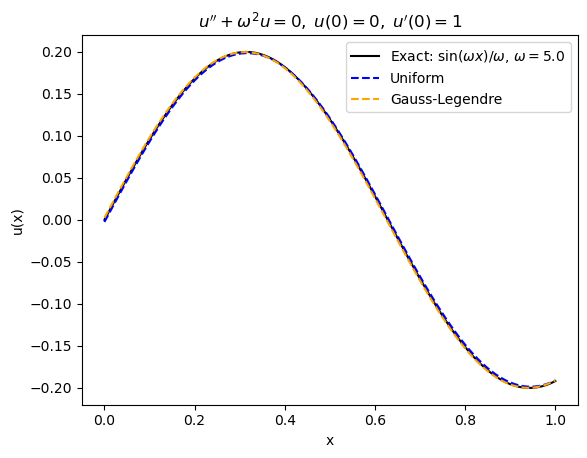

In [7]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import roots_legendre

# global constant
# frequency parameter for IVP u'' + omega^2 u = 0
omega = 5.0

# define the PINN architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

# helper to compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )[0]

# compute the PINN loss for the IVP
def compute_loss(model: nn.Module, x: torch.Tensor):
    # interior residual for u'' + omega^2 u = 0
    x.requires_grad_(True)
    u   = model(x)
    du  = grad(u, x)
    d2u = grad(du, x)
    residual = d2u + omega**2 * u
    interior_loss = torch.mean(residual**2)

    # initial conditions at x=0: u(0)=0, u'(0)=1
    x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    u0  = model(x0)
    du0 = grad(u0, x0)
    ic_loss = (u0 - 0.0)**2 + (du0 - 1.0)**2

    return interior_loss + ic_loss

# generate collocation points on [0,1]
def generate_collocation_points(method='uniform', num_points=100):
    if method == 'uniform':
        x_vals = np.linspace(0, 1, num_points)
    elif method == 'gauss_legendre':
        nodes, _ = roots_legendre(num_points)
        x_vals = 0.5 * (nodes + 1.0)   # map from [-1,1] to [0,1]
    else:
        raise ValueError('Unsupported quadrature method')

    return torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# training routine
def train_PINN(x_train: torch.Tensor):
    model     = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(4000):
        loss = compute_loss(model, x_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f'Full Training Epoch {epoch}, Loss: {loss.item():.6f}')

    return model

# helper to train and plot
def create_results(x_train: torch.Tensor, color='red', label=''):
    model  = train_PINN(x_train)
    y_pred = model(x_train).detach().numpy()
    plt.plot(x_train.detach().numpy(),
             y_pred,
             linestyle='--',
             color=color,
             label=label
             )

if __name__ == '__main__':
    # exact solution: u(x) = sin(omega x) / omega
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_true = (torch.sin(omega * x_test) / omega).numpy()
    plt.plot(x_test.numpy(),
             y_true,
             color='black',
             label=fr'Exact: $\sin(\omega x)/\omega$, $\omega={omega}$'
             )

    # collocation sets
    uniform_points = generate_collocation_points(method='uniform')
    gauss_points   = generate_collocation_points(method='gauss_legendre')

    create_results(uniform_points, color='blue',  label='Uniform')
    create_results(gauss_points,   color='orange', label='Gauss-Legendre')

    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(r"$u'' + \omega^2 u = 0,\;u(0)=0,\;u'(0)=1$")
    plt.legend()
    plt.show()


In [ ]:
# PINN solution differ for various omegas. Solution depends on parameter omega. 

Epoch 0, Loss: 0.226035
Epoch 500, Loss: 0.001642
Epoch 1000, Loss: 0.000556
Epoch 1500, Loss: 0.000059
Epoch 2000, Loss: 0.000019
Epoch 2500, Loss: 0.000306
Epoch 3000, Loss: 0.002464
Epoch 3500, Loss: 0.000016
Epoch 0, Loss: 0.311199
Epoch 500, Loss: 0.001506
Epoch 1000, Loss: 0.000294
Epoch 1500, Loss: 0.000130
Epoch 2000, Loss: 0.000045
Epoch 2500, Loss: 0.000164
Epoch 3000, Loss: 0.000015
Epoch 3500, Loss: 0.000248


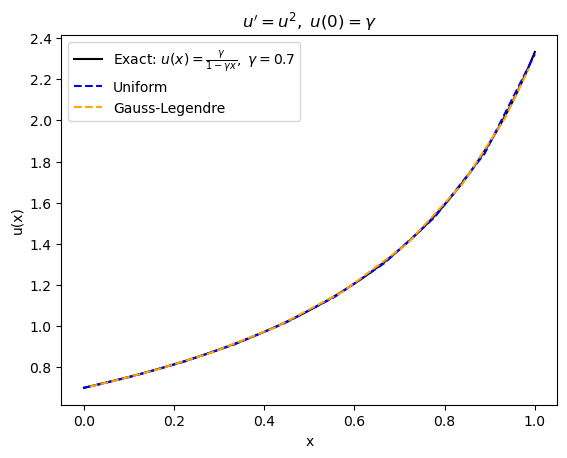

In [4]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import roots_legendre

# global constant
# initial condition parameter for IVP u' = u^2, x ∈ [0,1], u(0)=gamma
gamma = 0.7

# define the PINN architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # 2 hidden layers of 20 neurons each with Tanh activations
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

# gradient helper
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]

# compute the PINN loss for the nonlinear IVP
# equation: u' - u^2 = 0, with u(0)=gamma
def compute_loss(model: nn.Module, x: torch.Tensor):
    # enable gradient tracking for x
    x.requires_grad_(True)
    # network output
    u = model(x)
    # first derivative
    du = grad(u, x)
    # PDE residual: u' - u^2
    residual = du - u**2
    interior_loss = torch.mean(residual**2)

    # initial condition at x=0: u(0) = gamma
    x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=False)
    u0 = model(x0)
    ic_loss = (u0 - gamma)**2

    return interior_loss + ic_loss

# generate collocation points in [0,1]
def generate_collocation_points(method='uniform', num_points=10):
    if method == 'uniform':
        x_vals = np.linspace(0, 1, num_points)
    elif method == 'gauss_legendre':
        nodes, _ = roots_legendre(num_points)
        x_vals = 0.5 * (nodes + 1.0)  # map [-1,1]→[0,1]
    else:
        raise ValueError('Unsupported quadrature method')
    return torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# training routine
def train_PINN(x_train: torch.Tensor):
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(4000):
        loss = compute_loss(model, x_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

    return model

# helper to train and plot solution
def create_results(x_train: torch.Tensor, color='red', label=''):
    model = train_PINN(x_train)
    y_pred = model(x_train).detach().numpy()
    plt.plot(x_train.detach().numpy(), y_pred,
             linestyle='--', color=color, label=label)

if __name__ == '__main__':
    # analytic solution: u(x) = gamma / (1 - gamma * x) for gamma != 0
    x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_true = (gamma / (1 - gamma * x_test)).numpy()
    plt.plot(x_test.numpy(), y_true,
             color='black', label=fr'Exact: $u(x)=\frac{{\gamma}}{{1 - \gamma x}},\;\gamma={gamma}$')

    # collocation sets
    uniform_points     = generate_collocation_points(method='uniform')
    gauss_legendre_pts = generate_collocation_points(method='gauss_legendre')

    # train & plot PINN solutions
    create_results(uniform_points,     color='blue',  label='Uniform')
    create_results(gauss_legendre_pts, color='orange', label='Gauss-Legendre')

    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title(r"$u' = u^2,\;u(0)=\gamma$")
    plt.legend()
    plt.show()


In [ ]:
# PINN solution differs for various gammas. Solution depends on parameter. For gamma>1, we get false result. 